In [2]:
from omegaconf import DictConfig
import hydra
from hydra import initialize, compose
import torch
import numpy as np
from tqdm import tqdm

from model import load_model
from data import PennFudanDataset, resize_with_long_edge, center_pad
from utils import get_iou, compute_dice_score, dice_loss
from PIL import Image
import torchvision


In [3]:


# Initialize Hydra and load the configuration
initialize(config_path="conf")
cfg = compose(config_name="config")

# Print the configuration to verify
print(cfg)

{'output_dir': 'tmp/output/first', 'wandb': {'project': 'pedestrian-detection', 'name': 'main'}, 'model': {'in_channels': 3, 'out_channels': 1, 'kernel_size': 3, 'main_channel': 8, 'depth': 3, 'spatial_scale_factor': 2, 'channel_scale_factor': 4}, 'data': {'data_root': 'tmp/data/PennFudanPed'}, 'train': {'batch_size': 16, 'num_epochs': 300, 'num_workers': 4, 'img_size': 128, 'dtype': 'bfloat16', 'device': 'cuda', 'seed': 42, 'optimizer': {'_target_': 'torch.optim.Adam', 'lr': 0.0001}, 'scheduler': {'_target_': 'utils.CosineAnnealingWarmupRestarts', 'total_epochs': '${train.num_epochs}', 'warmup_epochs': None, 'min_lr': None, 'max_lr': '${train.optimizer.lr}'}}}


/tmp/ipykernel_105775/1136870114.py:2: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  initialize(config_path="conf")


# test set evaluation

In [4]:

model = load_model('tmp/output/first/epoch00064', cfg.model)
img_transform = torchvision.transforms.Compose([
    torchvision.transforms.Lambda(lambda x: resize_with_long_edge(x, cfg.train.img_size)),
    torchvision.transforms.Lambda(center_pad),
    torchvision.transforms.ToTensor(),
])

mask_transform = torchvision.transforms.Compose([
    torchvision.transforms.Lambda(lambda x: resize_with_long_edge(x, cfg.train.img_size, Image.NEAREST)),
    torchvision.transforms.Lambda(center_pad),
    torchvision.transforms.Lambda(lambda x: torch.as_tensor(np.array(x).astype(bool))),
])


test_dataset = PennFudanDataset(
    root=cfg.data.data_root,
    img_transforms=img_transform,
    mask_transforms=mask_transform,
    split='test',
)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=4,
    num_workers=1,
    shuffle=False,
)

device, dtype = torch.device('cuda'), torch.float32
ious, soft_dice_losses, dice_scores = [], [], []

model.eval()
model = model.to(device)
with torch.no_grad():
    for images, masks in tqdm(test_loader, leave=False):
        images = images.to(device, dtype=dtype)
        masks = masks.to(device)
        outputs = model(images)
        pred_masks = outputs > 0
    ious.extend(get_iou(pred_masks, masks).tolist())
    soft_dice_losses.append(dice_loss(outputs.sigmoid(), masks).tolist())
    dice_scores.append(compute_dice_score(pred_masks, masks).tolist())

ious = np.mean(ious)
dice_scores = np.mean(dice_scores)
soft_dice_losses = np.mean(soft_dice_losses)
print(f'Test set: IoU: {ious}, Dice Score: {dice_scores}, Soft Dice Loss: {soft_dice_losses}')




Test set: IoU: 0.7282012584100946, Dice Score: 0.7950285077095032, Soft Dice Loss: 0.2354467511177063


# in distribution test set visualization

sample 0 in batch: 


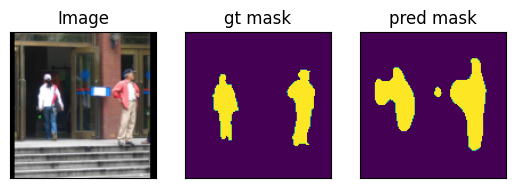

sample 1 in batch: 


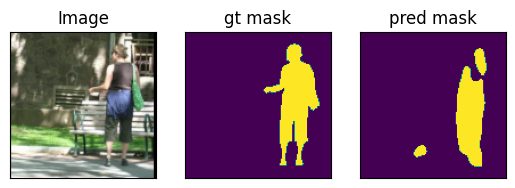

sample 2 in batch: 


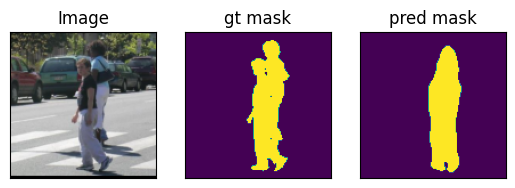

sample 3 in batch: 


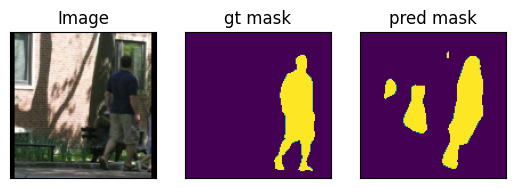

In [5]:
# visualize the results in test set
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F
images, masks = next(iter(test_loader))
images = images.to(device)
masks = masks.to(device)
outputs = model(images)
pred_masks = outputs > 0
for i, (image, mask, pred_mask) in enumerate(zip(images, masks, pred_masks)):
    print(f"sample {i} in batch: ")
    image = F.to_pil_image(image.cpu())
    mask = F.to_pil_image(mask.cpu().float())
    pred_mask = F.to_pil_image(pred_mask.cpu().float())
    plt.figure()
    plt.subplot(1, 3, 1)
    # mark the image
    plt.title('Image')
    plt.xticks([])
    plt.yticks([])
    plt.imshow(image)
    plt.subplot(1, 3, 2)
    plt.title('gt mask')
    plt.xticks([])
    plt.yticks([])
    plt.imshow(mask)
    plt.subplot(1, 3, 3)
    plt.title('pred mask')
    plt.xticks([])
    plt.yticks([])
    plt.imshow(pred_mask)
    plt.show()

# out of distribution image

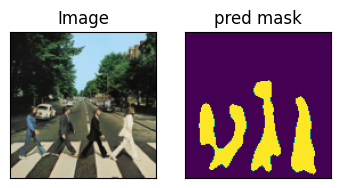

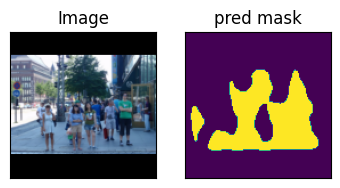

In [21]:
import requests

def get_url_batch(urls, transform):
    images = []
    for url in urls:
        image = Image.open(requests.get(url, headers=headers, stream=True).raw).convert('RGB')
        images.append(transform(image))
    return torch.stack(images)
image_urls = [
    "https://upload.wikimedia.org/wikipedia/en/4/42/Beatles_-_Abbey_Road.jpg",
    "https://upload.wikimedia.org/wikipedia/commons/a/ad/Forumhelsinkikauppakeskuskadunylitys.JPG"
]
headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.102 Safari/537.36'}
images = get_url_batch(image_urls, img_transform).to(device)
output = model(images)
pred_mask = output > 0
pred_mask = pred_mask.squeeze(0)
for image, pred_mask in zip(images, pred_mask):
    image = F.to_pil_image(image.cpu().squeeze(0))
    pred_mask = F.to_pil_image(pred_mask.cpu().float())
    plt.figure()
    plt.subplot(1, 3, 1)
    # mark the image
    plt.title('Image')
    plt.xticks([])
    plt.yticks([])
    plt.imshow(image)
    plt.subplot(1, 3, 2)
    plt.title('pred mask')
    plt.xticks([])
    plt.yticks([])
    plt.imshow(pred_mask)